In [36]:
import os
import sys
sys.path.append('src/iVAE')
import yaml
import matplotlib.pyplot as plt

from src.iVAE.data import SyntheticDataset
from src.iVAE.models import cleanIVAE
from src.iVAE.models import load_checkpoint

import torch
from torch import optim

import numpy as np 
import matplotlib.pyplot as plt
import sys
sys.path.append('src/fast_ica')
from fast_ica import FastICA
from sklearn.decomposition import FastICA as sk_FastICA

import pandas as pd
import seaborn as sns


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
config_path = os.path.join("experiments_results/exp_configs/config_exp_1.yaml")
checkpoint_path = os.path.join("experiments_results/checkpoints/1/1_seed_0_ckpt_best.pth")
dataset_path = os.path.join("experiments_results/datasets/")
config = yaml.safe_load(open(config_path, "r"))

In [4]:
dset = SyntheticDataset(
        dataset_path,
        config["nps"],
        config["ns"],
        config["dl"],
        config["dd"],
        config["nl"],
        config["s"],
        config["p"],
        config["act"],
        uncentered=config["uncentered"],
        noisy=config["noisy"],
        double= config['gamma'] > 0,
        one_hot_labels=config["one_hot"],
        simple_mixing=config["simple_mixing"],
    )
d_data, d_latent, d_aux = dset.get_dims()

loading data from experiments_results/datasets/tcl_1000_40_5_5_3_1_gauss_xtanh_one_hot.npz


In [29]:
config

{'a': 100,
 'act': 'xtanh',
 'activation': 'xtanh',
 'anneal': False,
 'anneal_epoch': 20,
 'b': 1,
 'batch_norm': False,
 'batch_size': 64,
 'c': 0,
 'checkpoint': True,
 'd': 10,
 'dd': 5,
 'dl': 5,
 'epochs': 100,
 'gamma': 0,
 'hidden_dim': 100,
 'ica': True,
 'initialize': True,
 'log': True,
 'lr': 0.01,
 'n_layers': 3,
 'nl': 3,
 'no_scheduler': False,
 'noisy': False,
 'nps': 1000,
 'ns': 40,
 'one_hot': True,
 'p': 'gauss',
 's': 1,
 'scheduler_tol': 3,
 'shuffle': True,
 'simple_mixing': False,
 'staircase': False,
 'tcl': False,
 'uncentered': False}

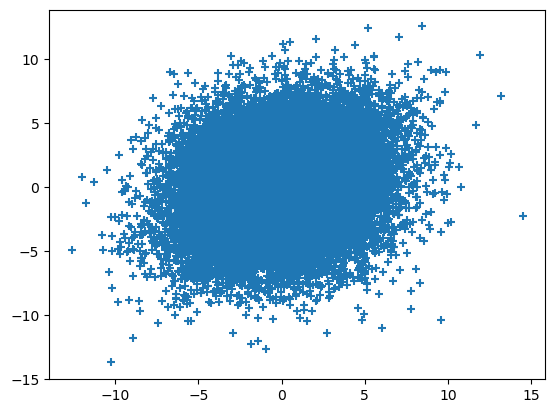

In [5]:
plt.scatter(dset.x[:, 0], dset.x[:, 2], marker="+")

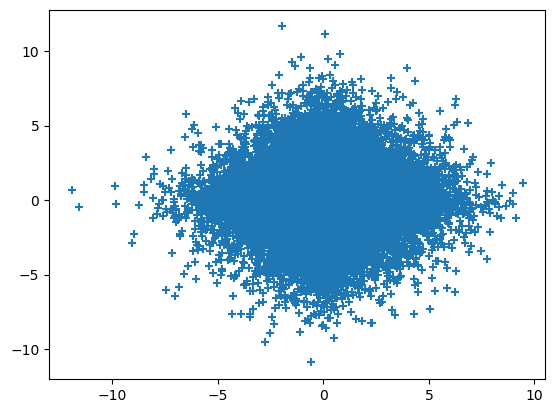

In [6]:
plt.scatter(dset.s[:, 0], dset.s[:, 2], marker="+")

## FastICA

In [9]:
ica = FastICA(n_components=dset.x.shape[1], tol=1e-10)
S_ = ica.fit_transform(dset.x.detach().numpy(), method='parallel')
S_

array([[ 0.06168406, -0.16280991,  0.72933654,  0.46576708, -0.06499501],
       [ 0.56519315, -0.09996714,  1.24089199,  0.31754849,  2.12515928],
       [-0.01355306, -0.23308087, -0.1341079 , -0.7736498 ,  0.13562986],
       ...,
       [-0.64154555, -0.09006484,  0.32946128,  0.32849363,  0.96013889],
       [-1.55470347, -2.01821073,  0.21441597, -0.24026624, -2.90418516],
       [ 0.4287152 , -0.50888668,  0.55548917, -0.77768064, -0.69737162]])

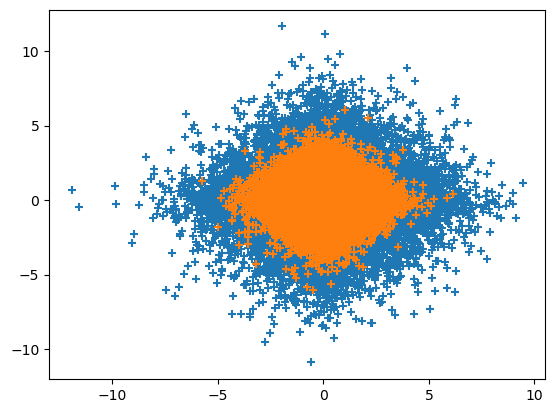

In [10]:
plt.scatter(dset.s[:, 0], dset.s[:, 2], marker="+")
plt.scatter(S_[:, 0], S_[:, 2], marker="+")

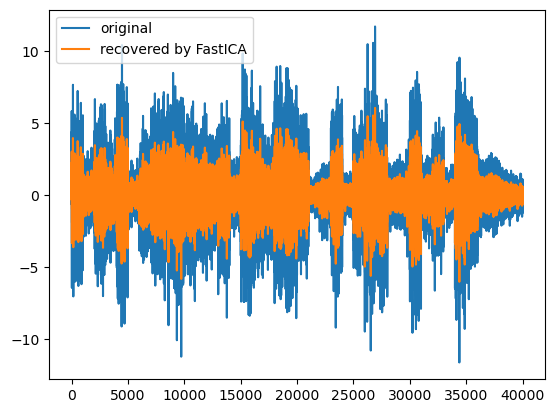

In [27]:
plt.plot(dset.s[:, 1], label='original')
plt.plot(S_[:, 2], label='recovered by FastICA')
plt.legend()
plt.savefig('source_fastica_1.pdf')

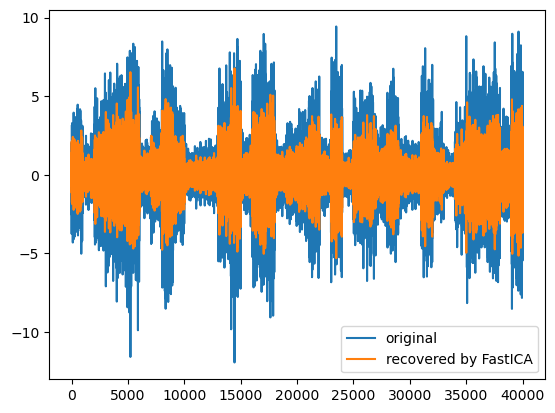

In [28]:
plt.plot(dset.s[:, 0], label='original')
plt.plot(S_[:, 4], label='recovered by FastICA')
plt.legend()
plt.savefig('source_fastica_2.pdf')

In [38]:
number_of_points_by_segment = 1000
number_of_segments = 5
dimension_of_latent_space = 2
dimension_of_data_space = 2
seed = 1
prior = 'gauss'

simple_mixing = True 
linear_transformation_type="uniform"
activation = 'xtanh' # if simple_mixing is True, activation is not used
slope = 0.1 # if simple_mixing is True, slope is not used
number_of_mixing_layers = 10 # if simple_mixing is True, number_of_mixing_layers is not used
repeat_linearity = False # if simple_mixing is True, repeat_linearity is not used

uncentered = True
# centers = np.random.uniform(-15, 15, (number_of_segments, dimension_of_data_space))
centers = np.array([[-5,6], [0,0], [0,-4], [1,2], [6,0 ]])

var_bounds = np.array([0.5, 3])

noisy = 0.01
staircase = False

In [41]:
dataset = SyntheticDataset(
    "./", 
    number_of_points_by_segment, 
    number_of_segments, 
    dimension_of_latent_space, 
    dimension_of_data_space, 
    number_of_mixing_layers, 
    seed, 
    prior,
    activation, 
    uncentered, 
    noisy, 
    one_hot_labels=True, 
    simple_mixing=simple_mixing,
    centers=centers,
)
source, mixture, segment_labels = dataset.s, dataset.x, dataset.u
indices = np.argmax(segment_labels, axis=1)

Creating dataset ./tcl_1000_5_2_2_10_1_gauss_xtanh_u_noisy_one_hot.npz ...
 ... done
loading data from ./tcl_1000_5_2_2_10_1_gauss_xtanh_u_noisy_one_hot.npz


In [42]:
df = pd.concat([
    pd.DataFrame(source, columns=[f"s_{i}" for i in range(source.shape[1])]),
    pd.DataFrame(mixture, columns=[f"x_{i}" for i in range(mixture.shape[1])]),
    pd.DataFrame(indices, columns=["segment"])
], axis=1)

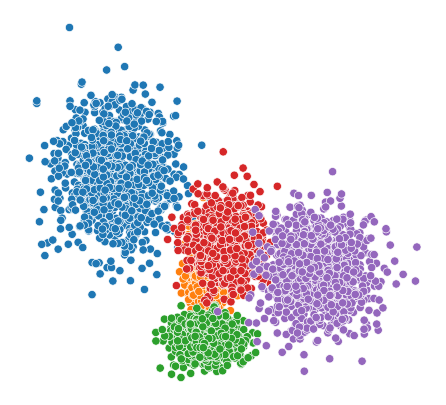

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(5.5, 5)) 
sns.scatterplot(data=df, x="s_0", y="s_1", hue="segment", palette="tab10", ax=ax)
ax.legend().remove()
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
# remove border
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
# plt.savefig('original_join.pdf')

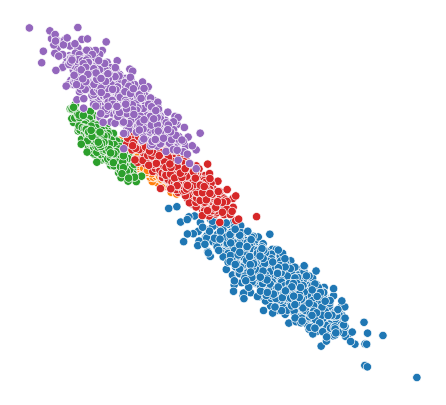

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(5.5, 5)) 
sns.scatterplot(data=df, x="x_0", y="x_1", hue="segment", palette="tab10", ax=ax)
ax.legend().remove()
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
# remove border
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.savefig('mixture_linear_join.pdf')

In [45]:
ica = FastICA(n_components=dimension_of_latent_space, tol=1e-10, max_iter=10000)
fast_ica_source_predict = ica.fit_transform(mixture, method='parallel')
df_fast_ica = pd.concat([
  df,
  pd.DataFrame(fast_ica_source_predict, columns=[f"fast_ica_s_{i}" for i in range(fast_ica_source_predict.shape[1])]),
], axis=1)

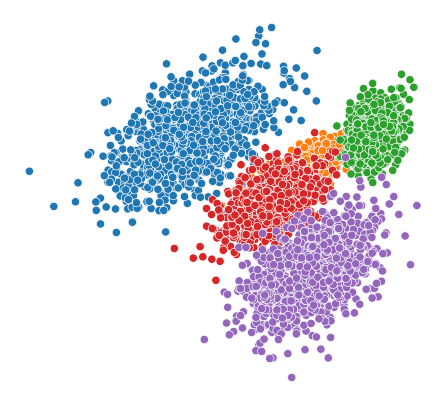

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(5.5, 5)) 
sns.scatterplot(data=df_fast_ica, x="fast_ica_s_0", y="fast_ica_s_1", hue="segment", palette="tab10", ax=ax)
ax.legend().remove()
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
# remove border
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.savefig('fastica_linear_join.pdf')